Problem Set 1: Text Classification
=============

In this problem set, you will build a system for automatically classifying song lyrics comments by era. You will:

- Do some basic text processing, tokenizing your input and converting it into a bag-of-words representation
- Build a machine learning classifier based on the generative model, using Naive Bayes
- Evaluate your classifiers and examine what they have learned
- Build a machine learning classifier based on the discriminative model, using Perceptron
- Build a logistic regression classifier using PyTorch
- Implement techniques to improve your classifier

# 0. Setup

In order to develop this assignment, you will need [python 3](https://www.python.org/downloads/) and the following libraries. Most if not all of these are part of [conda](https://docs.conda.io/en/latest/miniconda.html), so a good starting point would be to install that.

- [jupyter](http://jupyter.readthedocs.org/en/latest/install.html)
- [scipy](https://www.scipy.org/install.html)
- numpy (This will come if you install scipy like above, but if not install separately)
- [matplotlib](http://matplotlib.org/users/installing.html)
- [nosetests](https://nose.readthedocs.org/en/latest/)
- [pandas](http://pandas.pydata.org/) Dataframes
- [torch](https://pytorch.org/get-started/locally/)

Here is some help on installing packages in python: https://packaging.python.org/installing/. You can use ```pip --user``` to install locally without sudo.

## About this assignment

- This is a Jupyter notebook. You can execute cell blocks by pressing control-enter.
- Most of your coding will be in the python source files in the directory ```mynlplib```.
- The directory ```tests``` contains unit tests that will be used to grade your assignment, using ```nosetests```. You should run them as you work on the assignment to see that you're on the right track. You are free to look at their source code, if that helps -- though most of the relevant code is also here in this notebook. Learn more about running unit tests at http://pythontesting.net/framework/nose/nose-introduction/
- You may want to add more tests, but that is completely optional. 
- **To submit this assignment, run the script ```make-submission.sh```, and submit the tarball ```pset1-submission.tgz``` on Canvas.**

In [1]:
import sys
from importlib import reload

In [2]:
print('My Python version')

print('python: {}'.format(sys.version))

My Python version
python: 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [3]:
import nose

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
from torch import optim

%matplotlib inline

In [4]:
print('My library versions')

print('pandas: {}'.format(pd.__version__))
print('numpy: {}'.format(np.__version__))
print('scipy: {}'.format(sp.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('nose: {}'.format(nose.__version__))
print('torch: {}'.format(torch.__version__))

My library versions
pandas: 1.0.3
numpy: 1.19.1
scipy: 1.4.1
matplotlib: 3.1.3
nose: 1.3.7
torch: 1.6.0


To test whether your libraries are the right version, run:

`nosetests tests/test_environment.py`

In [5]:
# use ! to run shell commands in notebook
! nosetests tests/test_environment.py

.
----------------------------------------------------------------------
Ran 1 test in 0.000s

OK


# 1. Preprocessing

Total: 8 points

Read the data into a dataframe

In [6]:
df_train = pd.read_csv('lyrics-train.csv')

A dataframe is a structured representation of your data. You can preview a dataframe using `head()`

In [7]:
df_train.head()

,Era,Lyrics
0,pre-1980,come on come on let me show you where its at a...
1,1980s,welcome to the big time youre bound to be a s...
2,pre-1980,once i believed that when love came to me it ...
3,2000s,i took my love and i took it down climbed a m...
4,pre-1980,do do do do do do do do do do do do do do do ...


## Bags of words

Your first task is to convert the text to a bag-of-words representation. For this data, a lot of the preprocessing is already done: the text is lower-cased, and punctuation is removed. You need only create a `counter` for each instance.

- **Deliverable 1.1**: Complete the function `mynlplib.preproc.bag_of_words`. (2 points)
- **Test**: `nose tests/test_preproc.py:test_d1_1_bow`

In [8]:
from mynlplib import preproc

In [9]:
# run this block to update the notebook as you change the preproc library
reload(preproc);

In [10]:
y_tr,x_tr = preproc.read_data('lyrics-train.csv',preprocessor=preproc.bag_of_words)
y_dv,x_dv = preproc.read_data('lyrics-dev.csv',preprocessor=preproc.bag_of_words)

In [11]:
y_te,x_te = preproc.read_data('lyrics-test-hidden.csv',preprocessor=preproc.bag_of_words)

## Unseen words

One challenge for classification is that words will appear in the test data that do not appear in the training data. Compute the number of words that appear in `lyrics-dev.csv`, but not in `lyrics-train.csv`. To do this, implement the following deliverables:

- **Deliverable 1.2**: implement `mynlplib.preproc.aggregate_counts`, a counter of all words in a list of bags-of-words.  (2 points)
- **Deliverable 1.3**: implement `mynlplib.preproc.compute_oov`, returning a list of words that appear in one list of bags-of-words, but not another.  (2 points)
- **Tests**: `tests/test_preproc.py:test_d1_2_agg`, `tests/test_preproc.py:test_d1_3a_oov`

In [12]:
from collections import Counter

In [13]:
reload(preproc);

In [14]:
counts_dv = preproc.aggregate_counts(x_dv)

You can see the most common items in a counter by calling `counts.most_common()`:

In [15]:
counts_dv.most_common(5)

[('you', 5542), ('i', 5535), ('the', 5061), ('to', 3203), ('and', 2953)]

In [16]:
counts_tr = preproc.aggregate_counts(x_tr)

In [17]:
len(preproc.compute_oov(counts_dv,counts_tr))

2677

In [18]:
len(preproc.compute_oov(counts_tr,counts_dv))

30459

In [19]:
preproc.oov_rate(counts_dv,counts_tr)

0.297246280257606

30% of the words in the dev set do not appear in the training set.

## Power laws

Word count distributions are said to follow [power law](https://en.wikipedia.org/wiki/Power_law) ([Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law)) distributions. 

In practice, this means that a log-log plot of frequency against rank is nearly linear. Let's see if this holds for our data.

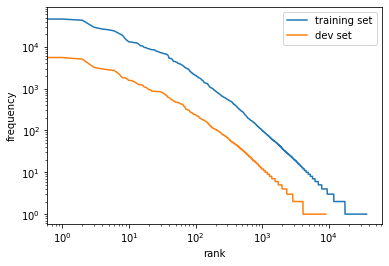

In [20]:
plt.loglog([val for word,val in counts_tr.most_common()])
plt.loglog([val for word,val in counts_dv.most_common()])
plt.xlabel('rank')
plt.ylabel('frequency')
plt.legend(['training set','dev set']);

**Reflect**: The dataset we are working with does not include capitalization. How do you think this figure would change if capitalization distinctions were included?

## Pruning the vocabulary

Let's prune the vocabulary to include only words that appear at least ten times in the training data.

- **Deliverable 1.4:** Implement `preproc.prune_vocabulary` (2 points)
- **Test**: `tests/test_preproc.py:test_d1_4_prune`

In [21]:
reload(preproc);

In [22]:
x_tr_pruned, vocab = preproc.prune_vocabulary(counts_tr,x_tr,10)
x_dv_pruned, _ = preproc.prune_vocabulary(counts_tr,x_dv,10)
x_te_pruned, _ = preproc.prune_vocabulary(counts_tr,x_te,10)

In [23]:
len(vocab)

4875

In [24]:
i = 94
print(len(x_dv[i]),len(x_dv_pruned[i]))
print(sum(x_dv[i].values()),sum(x_dv_pruned[i].values()))

88 79
187 176


# 2. Linear classification

Now you'll implement the linear classification rule, $\hat{y} = \text{argmax}_y \theta^{\top} f(x,y)$.

You will use these functions in all classifiers in this assignment.

Total: 8 points

In [25]:
from mynlplib import clf_base
reload(clf_base)

from mynlplib import constants
reload(constants);

Recall from the reading that the feature function vector $f(x,y)$ can be viewed as a dict, in which the values are counts, and the keys are tuples $(y,x_j)$, where $y$ is a label and $x_j$ is a base feature.

- **Deliverable 2.1**: Implement the function ```make_feature_vector``` in ```clf_base.py```. (4 points)
- **Test**: `tests/test_classifier.py:test_d2_1_featvec`

Note that you must also include the offset feature, ```mynlplib.constants.OFFSET```.

Desired output is shown below:

In [26]:
fv = clf_base.make_feature_vector({'test':1,'case':2},'1980s')

In [27]:
print(fv)

{('1980s', 'test'): 1, ('1980s', 'case'): 2, ('1980s', '**OFFSET**'): 1}


Let's compute the entire set of labels.

In [28]:
labels = set(y_tr) #figure out all possible labels
print(labels)

{'pre-1980', '1980s', '2000s', '1990s'}


Now implement the prediction rule, $\hat{y} = \text{argmax}_y \theta^{\top} f(x,y)$.

- **Deliverable 2.2**: Implement the function ```predict``` in ```clf_base.py```. (4 points)
- **Test**: `tests/test_classifier.py:test_d2_2_predict`

The output should be:

- A predicted label
- The scores of all labels

This function will be called **a lot**, so try to make it fast. You don't need to do anything crazy, but avoid making your code do silly extra work.

You can test this function using these simple hand-crafted weights.

In [29]:
from collections import defaultdict

In [30]:
# weight vectors must be defaultdicts
theta_hand = defaultdict(float,
                         {('2000s','money'):0.1,
                          ('2000s','name'):0.2,
                          ('1980s','tonight'):0.1,
                          ('2000s','man'):0.1,
                          ('1990s','fly'):0.1,
                          ('pre-1980',constants.OFFSET):0.1
                         })

In [31]:
clf_base.predict(x_tr_pruned[0],theta_hand,labels)

('2000s',
 {'pre-1980': 0.1, '1980s': 0.0, '2000s': 1.3000000000000003, '1990s': 0.0})

Now let's see how good these weights are, by evaluating on the dev set.

In [32]:
from mynlplib import evaluation
reload(evaluation);

In [33]:
# this applies your predict function to all the instances in ```x_dv```
y_hat = clf_base.predict_all(x_dv_pruned,theta_hand,labels)
print(evaluation.acc(y_hat,y_dv))

0.3422222222222222


**Reflect**: What accuracy corresponds to random chance on this dataset?

# 3. Naive Bayes

You'll now implement a Naive Bayes classifier, as described in Eisenstein Ch. 2.

Total: 16 points

In [34]:
from mynlplib import naive_bayes
reload(naive_bayes);

- **Deliverable 3.1**: (warmup) implement ```get_corpus_counts``` in ```naive_bayes.py```. (4 points)
- **Test**: `tests/test_classifier.py:test_d3_1_corpus_counts`

This function should compute the word counts for a given label.

In [35]:
eighties_counts = naive_bayes.get_corpus_counts(x_tr_pruned,y_tr,"1980s");
print(eighties_counts['today'])
print(eighties_counts['yesterday'])

50
14


- **Deliverable 3.2**: Implement ```estimate_pxy``` in ```naive_bayes.py```. (4 points)
- **Test**: `tests/test_classifier.py:test_d3_2_pxy`

This function should compute the *smoothed* multinomial distribution $\log P(x \mid y)$ for a given label $y$.

Hint: note that this function takes the vocabulary as an argument. You have to assign a probability even for words that do not appear in documents with label $y$, if they are in the vocabulary.

You can use ```get_corpus_counts``` in this function if you want to, but you don't have to.

In [36]:
log_pxy = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"1980s",0.1,vocab)

Probabilities must sum to one! (or very close)

In [37]:
sum(np.exp(list(log_pxy.values())))

0.9999999999999805

Let's look at the log-probabilities of the words from the hand-tuned weights

In [38]:
print({word:log_pxy[word] for (_,word),weight in theta_hand.items() if weight>0})

{'money': -7.689562807416732, 'name': -7.568324713816848, 'tonight': -6.216637557007501, 'man': -6.631876946457839, 'fly': -8.636944126360918, '**OFFSET**': 0.0}


In [39]:
log_pxy_more_smooth = naive_bayes.estimate_pxy(x_tr_pruned,y_tr,"1980s",10,vocab)

In [40]:
print({word:log_pxy_more_smooth[word] for (_,word),weight in theta_hand.items() if weight>0})

{'money': -7.801363512554179, 'name': -7.691160372420565, 'tonight': -6.4054072405225515, 'man': -6.808471387093178, 'fly': -8.60745110429472, '**OFFSET**': 0.0}


- **Deliverable 3.3**: Now you are ready to implement ```estimate_nb``` in ```naive_bayes.py```. (4 points)
- **Test**: `tests/test_classifier.py:test_d3_3a_nb`



- The goal is that the score given by ```clf_base.predict``` is equal to the joint probability $P(x,y)$, as described in the notes.
- Don't forget the offset feature, whose weights should be set to the prior $\log P(y)$.
- The log-probabilities for the offset feature should not be smoothed.
- You can call the functions you have defined above, but you don't have to.

In [41]:
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,0.1)

In [42]:
clf_base.predict(x_tr_pruned[155],theta_nb,labels)

('2000s',
 {'pre-1980': -2136.8348423968023,
  '1980s': -2153.0199277981355,
  '2000s': -2099.2474010561396,
  '1990s': -2125.1966084804503})

In [43]:
y_hat = clf_base.predict_all(x_dv_pruned,theta_nb,labels)
print(evaluation.acc(y_hat,y_dv))

0.46444444444444444


In [44]:
# this block shows how we write and read predictions for evaluation
evaluation.write_predictions(y_hat,'nb-dev.preds')
y_hat_dv = evaluation.read_predictions('nb-dev.preds')
evaluation.acc(y_hat_dv,y_dv)

0.46444444444444444

In [45]:
# execute this block to write predictions for the test set
y_hat = clf_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-test.preds')

In [46]:
# you can't run this, but this how the grading code works
y_hat_te = evaluation.read_predictions('nb-test.preds')
evaluation.acc(y_hat_te,y_te)

0.0

- **Deliverable 3.4**: Write a function in ```naive_bayes.py``` called ```find_best_smoother```, which finds the smoothing value that gives best performance on the dev data.  (4 points)
- **Test**: `tests/test_classifier.py:test_d3_4a_nb_best`

Your function should trying at least the following values in `vals` below.

Then, using this smoothing value, run your Naive Bayes classifier on the test set, and output the results.

In [47]:
vals = np.logspace(-3,2,11)
print(vals)

[1.00000000e-03 3.16227766e-03 1.00000000e-02 3.16227766e-02
 1.00000000e-01 3.16227766e-01 1.00000000e+00 3.16227766e+00
 1.00000000e+01 3.16227766e+01 1.00000000e+02]


In [48]:
best_smoother, scores = naive_bayes.find_best_smoother(x_tr_pruned,y_tr,x_dv_pruned,y_dv,vals)

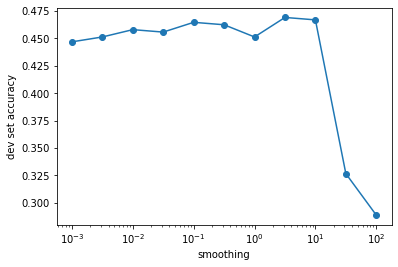

In [49]:
plt.semilogx(list(scores.keys()),list(scores.values()),'o-');
plt.xlabel('smoothing')
plt.ylabel('dev set accuracy');

**Reflect:**

- what might explain the dramatic drop in accuracy when the smoothing is increased from $10$ to $30$?
- before you check, predict whether the accuracy will continue to significantly drop if you further increase the smoothing to $10000$.

In [50]:
theta_nb = naive_bayes.estimate_nb(x_tr_pruned,y_tr,best_smoother)
y_hat = clf_base.predict_all(x_te_pruned,theta_nb,labels)
evaluation.write_predictions(y_hat,'nb-best-test.preds')

In [51]:
# you can't run this
y_hat = evaluation.read_predictions('nb-best-test.preds')
print(evaluation.acc(y_hat,y_te))

0.0


# 4. Perceptron 

Total: 12 points

The perceptron update is,

\begin{align}
\hat{y} = & \text{argmax}_y \theta^\top f(x,y)\\
\theta \gets & \theta + f(x,y) - f(x,\hat{y})
\end{align}

You will now implement this classifier, using the file ```mynlplib/perceptron.py```

In [52]:
from mynlplib import perceptron
reload(perceptron);

- **Deliverable 4.1**: Implement the perceptron *update*, $f(x,y) - f(x,\hat{y})$, in the function ```perceptron_update``` in ```perceptron.py```. (4 points)
- **Test**: `tests/test_perceptron.py:test_d4_1_perc_update`

In [53]:
theta_perc = defaultdict(float)

In [54]:
# no update when the prediction is correct
i=20
update = perceptron.perceptron_update(x_tr_pruned[i],y_tr[i],theta_perc,labels)
print(update)

defaultdict(<class 'float'>, {})


In [55]:
# update when the prediction is incorrect
i=110
y_hat,_ = clf_base.predict(x_tr_pruned[i],theta_perc,labels)
update =perceptron.perceptron_update(x_tr_pruned[i],y_tr[i],theta_perc,labels)
print(list(update.items())[:5])
print(len(update))
print(y_tr[i],constants.OFFSET,update[((y_tr[i],constants.OFFSET))])
print(y_hat,constants.OFFSET,update[((y_hat,constants.OFFSET))])

[(('2000s', 'with'), 1), (('2000s', 'her'), 1), (('2000s', 'lips'), 1), (('2000s', 'yeah'), 1), (('2000s', 'shes'), 2)]
122
2000s **OFFSET** 1
1980s **OFFSET** -1


In [56]:
update[(('1980s','with'))]

-1

In [57]:
len(update)

122

Now implement the perceptron algorithm. Your implementation should take as inputs:

- The training instances $x$
- The training labels $y$
- The number of iterations to train

It should use your ```update``` function, and it should return:

- weights $\theta$
- a list of the weights at each iteration


- **Deliverable 4.2**: Implement ```estimate_perceptron``` in ```perceptron.py``` (8 points)
- **Test**: `tests/test_perceptron.py:test_d4_2a_perc_estimate`

In [58]:
reload(perceptron);

In [59]:
theta_perc,theta_perc_history = perceptron.estimate_perceptron(x_tr_pruned[:10],y_tr[:10],3)

In [60]:
print(theta_perc[('1980s','its')])
print(theta_perc[('1980s','what')])

-15.0
4.0


In [61]:
theta_perc,theta_perc_history = perceptron.estimate_perceptron(x_tr_pruned,y_tr,20)

In [62]:
# run this to plot the accuracy over iterations
def plot_accs(weight_history,x_tr=x_tr_pruned,y_tr=y_tr,x_dv=x_dv_pruned,y_dv=y_dv):
    tr_accs = []
    dv_accs = []
    for theta in weight_history:
        tr_accs.append(evaluation.acc(clf_base.predict_all(x_tr,theta,labels),y_tr))
        dv_accs.append(evaluation.acc(clf_base.predict_all(x_dv,theta,labels),y_dv))
    plt.plot(tr_accs,'--')
    plt.plot(dv_accs)
    plt.xlabel('iteration')
    plt.ylabel('accuracy');
    plt.legend(['training','dev'],loc='lower right');
    return tr_accs,dv_accs

In [63]:
y_hat = clf_base.predict_all(x_dv_pruned,theta_perc,labels)
print(evaluation.acc(y_hat,y_dv));

0.4311111111111111


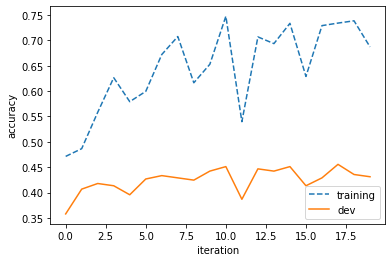

In [64]:
plot_accs(theta_perc_history);

In [65]:
# execute this code to write the predictions on the dev and training data
y_hat_dv = clf_base.predict_all(x_dv_pruned,theta_perc,labels)
evaluation.write_predictions(y_hat_dv,'perc-dev.preds')
y_hat_te = clf_base.predict_all(x_te_pruned,theta_perc,labels)
evaluation.write_predictions(y_hat_te,'perc-test.preds')

In [66]:
y_hat = evaluation.read_predictions('perc-dev.preds')
print(evaluation.acc(y_hat,y_dv))

0.4311111111111111


# 5. Logistic regression

Total: 14 points

Recall that logistic regression computes the conditional probability,
\begin{equation}
p(y \mid x; \theta) = \frac{\exp(\theta^{\top} f(x,y))}{\sum_{y'} \exp(\theta^{\top} f(x,y'))}
\end{equation}
and optimizes $\theta$ for the maximum conditional likelihood,
\begin{equation}
\log p(y^{(1:N)} \mid x^{(1:N)}; \theta) = \sum_{i=1}^{N} \log p(y^{(i)} \mid x^{(i)}; \theta)
\end{equation}
on the dataset $\mathcal{D} = \{(x^{(i)}, y^{(i)})\}_{i=1}^{N}$.

The optimization can be done by deriving gradients (Eisenstein Ch. 2.5) and updating $\theta$ iteratively (e.g., stochastic gradient descent) by hand, but many automatic differentiaion libraries can do it for you.

You will implement logistic regression in PyTorch.

## 5.1 Converting data to numpy

Numpy is a package for numerical computing in python.

You will need to convert your bag-of-words list of counters to a numpy array.

- **Deliverable 5.1**: Implement `preproc.py:make_numpy()` (4 points)
- **Test**: `test_pytorch/test_d5_1_numpy`
- **Hint**: one approach is to start with `numpy.zeros((height,width))`, and then fill in the cells by iterating through the bag-of-words list

In [67]:
X = np.zeros((4,2))
print(X)

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


In [68]:
X[1,1] = -1
X[2,0] = 1.5
print(X)

[[ 0.   0. ]
 [ 0.  -1. ]
 [ 1.5  0. ]
 [ 0.   0. ]]


In [69]:
reload(preproc);

In [70]:
X_tr = preproc.make_numpy(x_tr_pruned,vocab)
X_dv = preproc.make_numpy(x_dv_pruned,vocab)
X_te = preproc.make_numpy(x_te_pruned,vocab)

In [71]:
label_set = sorted(list(set(y_tr)))
print(label_set)

['1980s', '1990s', '2000s', 'pre-1980']


In [72]:
Y_tr = np.array([label_set.index(y_i) for y_i in y_tr])
Y_dv = np.array([label_set.index(y_i) for y_i in y_dv])

In [73]:
len(set(Y_tr))

4

## 5.2 Building a logistic regression model

- **Deliverable 5.2**: Complete `logreg.build_linear` (2 points)
- **Test**: `tests/test_pytorch.py:test_d5_2_logreg`

In [74]:
from mynlplib import logreg
reload(logreg);

In [75]:
torch.manual_seed(765);

In [76]:
X_tr_var = Variable(torch.from_numpy(X_tr.astype(np.float32)))
X_dv_var = Variable(torch.from_numpy(X_dv.astype(np.float32)))
X_te_var = Variable(torch.from_numpy(X_te.astype(np.float32)))

It's always a good idea to check the dimensions of your data first.

In [77]:
print(X_tr_var.size())
print(X_dv_var.size())

torch.Size([4000, 4875])
torch.Size([450, 4875])


In [78]:
model = logreg.build_linear(X_tr,Y_tr)

In [79]:
scores = model.forward(X_dv_var)
print(scores.data)

tensor([[-0.7673, -0.7583, -0.3767,  0.0325],
        [ 0.1110, -0.3801, -0.3979,  0.1642],
        [-1.8015, -0.5595, -3.5092,  0.9633],
        ...,
        [-0.3965,  0.0962, -0.4972, -0.1959],
        [-0.1721, -0.5167, -0.2574,  0.1571],
        [-0.3643,  0.0312, -0.4181,  0.4564]])


## 5.3 Adding a log-softmax layer

We've done it for you in PyTorch. Write your own log-softmax function in numpy and verify the results.

- **Deliverable 5.3**: Complete `logreg.log_softmax` (2 points)
- **Test**: `tests/test_pytorch.py:test_d5_3_log_softmax`

In [80]:
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [81]:
model.forward(X_dv_var)[:3].data

tensor([[-1.7426, -1.7336, -1.3520, -0.9427],
        [-1.1841, -1.6752, -1.6930, -1.1309],
        [-3.0214, -1.7793, -4.7291, -0.2566]])

In [82]:
model.forward(X_dv_var)[:3].exp().data

tensor([[0.1751, 0.1767, 0.2587, 0.3896],
        [0.3060, 0.1873, 0.1840, 0.3227],
        [0.0487, 0.1688, 0.0088, 0.7737]])

Notice that each row sums up to one.

In [83]:
model.forward(X_dv_var)[:3].exp().sum(dim=1).data

tensor([1., 1., 1.])

In [84]:
reload(logreg);

In [85]:
logreg.log_softmax(scores[:3].data.numpy()) 

array([[-1.742636  , -1.7335784 , -1.3519609 , -0.94274217],
       [-1.1840885 , -1.675237  , -1.6929629 , -1.1309158 ],
       [-3.0213718 , -1.7793286 , -4.7291145 , -0.25659686]],
      dtype=float32)

These should be very close to the PyTorch results.

## 5.4 Negative Log-Likelihood Loss

A loss function tells you how well your model is doing. It produces gradients that allows the optimizer to tune the model weights. We've done the Pytorch call for you, try implementing this yourself in numpy!

- **Deliverable 5.4**: Complete `logreg.nll_loss` (2 points)
- **Test**: `tests/test_pytorch.py:test_d5_4_nll_loss`

In [86]:
loss = torch.nn.NLLLoss()

In [87]:
Y_tr_var = Variable(torch.from_numpy(Y_tr))
Y_dv_var = Variable(torch.from_numpy(Y_dv))

In [88]:
logP = model.forward(X_tr_var)
print(loss.forward(logP, Y_tr_var).data)

tensor(1.5013)


In [89]:
reload(logreg);

In [90]:
logreg.nll_loss(logP.data.numpy(), Y_tr)

1.5013313

Again, This should be very similar to the PyTorch result above.

## 5.5 Putting everything together

An optimizer can be used to actually learn the weights. We provide the complete code below that you can train on in `logreg.train_model`.

In [91]:
reload(logreg);

In [92]:
# build a new model with a fixed seed
torch.manual_seed(765)
model = logreg.build_linear(X_tr,Y_tr)
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [93]:
model_trained, losses, accuracies = logreg.train_model(loss,model,
                                                       X_tr_var,
                                                       Y_tr_var,
                                                       X_dv_var=X_dv_var,
                                                       Y_dv_var = Y_dv_var,
                                                       num_its=100,
                                                       optim_args={'lr':0.02})

Epoch 1: Dev Accuracy: 0.2822222222222222
Epoch 11: Dev Accuracy: 0.29555555555555557
Epoch 21: Dev Accuracy: 0.29555555555555557
Epoch 31: Dev Accuracy: 0.31333333333333335
Epoch 41: Dev Accuracy: 0.31555555555555553
Epoch 51: Dev Accuracy: 0.38
Epoch 61: Dev Accuracy: 0.34444444444444444
Epoch 71: Dev Accuracy: 0.4444444444444444
Epoch 81: Dev Accuracy: 0.38
Epoch 91: Dev Accuracy: 0.41555555555555557


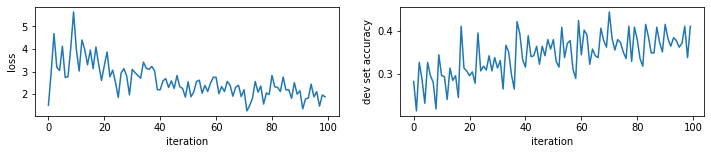

In [94]:
logreg.plot_results(losses,accuracies)

**Deliverable 5.5**
The noisy progress of the loss and dev set accuracy suggests that something is wrong with our hyperparameters. Tune the inputs to `train_model` until you can get to a dev set accuracy of at least 0.5. (4 points)

In [95]:
# build a new model with a fixed seed
torch.manual_seed(765)
model = logreg.build_linear(X_tr,Y_tr)
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))

In [96]:
model_trained, losses, accuracies = logreg.train_model(loss,model,
                                                       X_tr_var,
                                                       Y_tr_var,
                                                       X_dv_var=X_dv_var,
                                                       Y_dv_var = Y_dv_var,
                                                       num_its=100,
                                                       optim_args={'lr':0.02})

Epoch 1: Dev Accuracy: 0.2822222222222222
Epoch 11: Dev Accuracy: 0.29555555555555557
Epoch 21: Dev Accuracy: 0.29555555555555557
Epoch 31: Dev Accuracy: 0.31333333333333335
Epoch 41: Dev Accuracy: 0.31555555555555553
Epoch 51: Dev Accuracy: 0.38
Epoch 61: Dev Accuracy: 0.34444444444444444
Epoch 71: Dev Accuracy: 0.4444444444444444
Epoch 81: Dev Accuracy: 0.38
Epoch 91: Dev Accuracy: 0.41555555555555557


In [97]:
_, Y_hat_dv = model_trained.forward(X_dv_var).max(dim=1)
np.save('logreg-es-dev.preds.npy', Y_hat_dv.data.numpy())

In [98]:
acc = evaluation.acc(np.load('logreg-es-dev.preds.npy'),Y_dv_var.data.numpy())
print(acc)

0.4444444444444444


In [99]:
_, Y_hat_te = model.forward(X_te_var).max(dim=1)
np.save('logreg-es-test.preds.npy', Y_hat_te.data.numpy())

In [100]:
# You can't run this
Y_te = np.array([label_set.index(y_i) for y_i in y_te])
Y_te_var = Variable(torch.from_numpy(Y_te))
acc = evaluation.acc(np.load('logreg-es-test.preds.npy'),Y_te_var.data.numpy())
print(acc)

ValueError: 'hidden' is not in list

# 6. Feature analysis

Total: 8 points


## 6.1 Top Features for Naive Bayes and Perceptron

- **Deliverable 6.1**: Implement ```get_top_features_for_label``` in ```features.py```. (4 points)
- **Test**: `tests/test_features.py:test_d6_1_topfeat`

In [133]:
from mynlplib import features
reload(features);

In [134]:
features.get_top_features_for_label(theta_perc,'pre-1980',7)

[(('pre-1980', '**OFFSET**'), 949.0),
 (('pre-1980', 'lord'), 326.0),
 (('pre-1980', 'very'), 293.0),
 (('pre-1980', 'feelin'), 263.0),
 (('pre-1980', 'satisfied'), 251.0),
 (('pre-1980', 'darling'), 247.0),
 (('pre-1980', 'yes'), 235.0)]

In [135]:
features.get_top_features_for_label(theta_perc,'1990s',7)

[(('1990s', 'cuz'), 452.0),
 (('1990s', 'hit'), 368.0),
 (('1990s', 'sweat'), 342.0),
 (('1990s', 'prove'), 322.0),
 (('1990s', 'yo'), 285.0),
 (('1990s', 'saw'), 271.0),
 (('1990s', 'jam'), 268.0)]

## 6.2 Top Features for Logistic Regression

- **Deliverable 6.2**: Implement ```get_top_features_for_label_torch``` in ```features.py```. (4 points)
- **Test**: `tests/test_features.py:test_d6_2_topfeat_torch`

**Hint**: Extract linear layer weights from the PyTorch model.

In [124]:
reload(features);

Load a fixed model so we have reproducible results. Feel free to change it to your own model.

In [125]:
model_test = torch.load('tests/test_weights.torch')

/home/tedz/anaconda3/envs/11711/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/tedz/anaconda3/envs/11711/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/tedz/anaconda3/envs/11711/lib/python3.7/site-packages/torch/serialization.py:649: SourceChangeWarning: source code of class 'torch.nn.modules.activation.LogSoftmax' has changed. you can retrieve the 

In [126]:
features.get_top_features_for_label_torch(model_test, vocab, label_set,'pre-1980',5)

['love', 'lovin', 'and', 'baby', 'on']

In [127]:
features.get_top_features_for_label_torch(model_test, vocab, label_set,'1990s',7)

['here', 'power', 'jam', 'saw', 'yeah', 'want', 'yall']

# 7. Feature Engineering

Total: 14 points

## 7.1 Example Feature - Token-Type Ratio

You can have features other than bag of words in your model. For example, we can consider the token-type ratio for each song. The token-type ratio is:
\begin{equation}
\frac{\text{length of song in tokens}}{\text{number of distinct types}} = \frac{\sum_m w_m}{\sum_m \delta(w_m > 0)}
\end{equation}

- **Deliverable 7.1**: Implement ```get_token_type_ratio``` in ```features.py```. (2 points)
- **Test**: `tests/test_features.py:test_d7_1_token_type_ratio`

Return zero if the length of the song is zero.

In [136]:
reload(features);

Token-type ratios for the first five songs:

In [137]:
[features.get_token_type_ratio(X_tr[i]) for i in range(5)]

[5.083333333333333,
 2.6,
 1.9113924050632911,
 2.318840579710145,
 6.188679245283019]

## 7.2 Binning Your Features

Discretize your token-type ratio feature into bins: 


$\{ [0,1), [1,2), [2,3), [3,4), [4,5), [5,6), [6, \infty) \}$.

For each instance, there will be seven new features (one per bin). Exactly one of these features will have the value one; all others will have the value zero.

Use `np.concatenate` or `np.hstack` to concatenate your result to the variable X_tr.

- **Deliverable 7.2**: Implement ```concat_ttr_binned_features``` in ```features.py```. (4 points)
- **Test**: `tests/test_features.py:test_d7_2_discretize`

In [141]:
reload(features);

In [142]:
X_tr.shape

(4000, 4875)

In [143]:
X_tr_new = features.concat_ttr_binned_features(X_tr)
print(X_tr_new)
print(X_tr_new.shape)

[[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(4000, 4882)


In [144]:
X_dv_new = features.concat_ttr_binned_features(X_dv)
X_te_new = features.concat_ttr_binned_features(X_te)
X_tr_var = Variable(torch.from_numpy(X_tr_new.astype(np.float32)))
X_dv_var = Variable(torch.from_numpy(X_dv_new.astype(np.float32)))
X_te_var = Variable(torch.from_numpy(X_te_new.astype(np.float32)))

In [145]:
model = logreg.build_linear(X_tr_var,Y_tr)
model.add_module('softmax',torch.nn.LogSoftmax(dim=1))
loss = torch.nn.NLLLoss()

See if these features help!

In [146]:
model,losses,accuracies = logreg.train_model(loss,model,X_tr_var,Y_tr_var,
                                             Y_dv_var=Y_dv_var,X_dv_var = X_dv_var,
                                             num_its=500,status_frequency=100)

Epoch 1: Dev Accuracy: 0.31333333333333335
Epoch 101: Dev Accuracy: 0.4
Epoch 201: Dev Accuracy: 0.42444444444444446
Epoch 301: Dev Accuracy: 0.4444444444444444
Epoch 401: Dev Accuracy: 0.4577777777777778


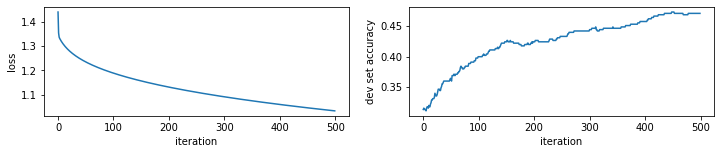

In [147]:
logreg.plot_results(losses,accuracies)

# 7.3 Bakeoff

**Deliverable 7.3**: Try to get the best accuracy possible. 

Some ideas:

- Better features
- Better optimization
- Better classifier, e.g. multilayer neural networks
- Better loss function
- Better preprocessing
- Dropout or other regularization scheme

### Rubric

Dev set
- $\geq 55\%$: 8 points
- $\geq 54\%$: 6 points
- $\geq 53\%$: 4 points
- $\geq 51\%$: 2 points

Test set
- Top ten in the class: 4 points (bonus)
- Top three in the class: 4 points (extra bonus)
- We'll also give 4 bonus points to particularly unique / creative / well-motivated solutions (with motivation to be included in the write-up).

Epoch 1: Dev Accuracy: 0.46444444444444444
Epoch 11: Dev Accuracy: 0.5155555555555555
Epoch 21: Dev Accuracy: 0.5311111111111111
Epoch 31: Dev Accuracy: 0.5155555555555555
Epoch 41: Dev Accuracy: 0.5488888888888889
Epoch 51: Dev Accuracy: 0.52
Epoch 61: Dev Accuracy: 0.5266666666666666
Epoch 71: Dev Accuracy: 0.5466666666666666
Epoch 81: Dev Accuracy: 0.56
Epoch 91: Dev Accuracy: 0.5577777777777778
Epoch 101: Dev Accuracy: 0.49333333333333335
Epoch 111: Dev Accuracy: 0.5755555555555556
Epoch 121: Dev Accuracy: 0.54
Epoch 131: Dev Accuracy: 0.44666666666666666
Epoch 141: Dev Accuracy: 0.5666666666666667
Epoch 151: Dev Accuracy: 0.5577777777777778
Epoch 161: Dev Accuracy: 0.5511111111111111
Epoch 171: Dev Accuracy: 0.54
Epoch 181: Dev Accuracy: 0.54
Epoch 191: Dev Accuracy: 0.5466666666666666
Epoch 201: Dev Accuracy: 0.5555555555555556
Epoch 211: Dev Accuracy: 0.5311111111111111
Epoch 221: Dev Accuracy: 0.5133333333333333
Epoch 231: Dev Accuracy: 0.49777777777777776
Epoch 241: Dev Accura

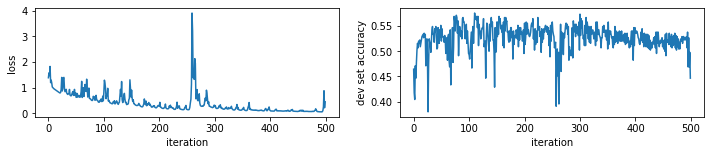

In [152]:
reload(logreg);
sizex = 1000
sizey = 1000

torch.manual_seed(1);

model = torch.nn.Sequential()
model.add_module("Linear1", torch.nn.Linear(X_tr_var.shape[1], sizex, bias=True))
model.add_module("Batch Norm 1", torch.nn.BatchNorm1d(1000))
model.add_module("tanh1", torch.nn.Tanh())
model.add_module("Linear3", torch.nn.Linear(sizey, len(set(Y_tr)), bias=True))
model.add_module('LogSoftmax', torch.nn.LogSoftmax(dim =1))
loss = torch.nn.NLLLoss()

model, losses, accuracies = logreg.train_model(loss, model, X_tr_var, Y_tr_var,
                                             Y_dv_var=Y_dv_var, X_dv_var = X_dv_var,
                                             num_its=500, status_frequency=10,
                                            optim_args={'lr': 0.1, 'momentum': 0.3})
logreg.plot_results(losses, accuracies)


In [153]:
_, Y_hat_dv = model.forward(X_dv_var).max(dim=1)
np.save('bakeoff-dev.preds.npy', Y_hat_dv.data.numpy())
evaluation.acc(np.load('bakeoff-dev.preds.npy'), Y_dv_var.data.numpy())

0.5755555555555556

In [154]:
_, Y_hat_te = model.forward(X_te_var).max(dim=1)
np.save('bakeoff-test.preds.npy', Y_hat_te.data.numpy())

In [155]:
# You can't run this
evaluation.acc(np.load('bakeoff-test.preds.npy'), Y_te_var.data.numpy())

NameError: name 'Y_te_var' is not defined

# 8. Write-up

Total: 20 points

You can start your write-up in any format you prefer (e.g., LaTeX, Markdown), but please remember to export to `pset1-writeup.pdf` upon submission. Also, you will be asked to post your Deliverable 8.2 and 8.3 on Piazza **after the due date (plus late days)**.

**Deliverable 8.1** (8 points):

Why is Naive Bayes a generative model? Why is Perceptron a discriminative model? Which family does logistic regression belong to? What do you see as a core difference between a generative model and a discriminative model?

**Deliverable 8.2** (4 points):

Briefly describe your bakeoff design.

**Deliverable 8.3** (8 points):

You will select a research paper at ACL, EMNLP or NAACL that performs *document* classification, using text. Summarize the paper, answering the following questions:

- What are the labels, and how were they obtained?
- Why is it interesting/useful to predict these labels?  
- What classifier(s) do they use, and the reasons behind their choice? Do they use linear classifiers like the ones in this problem set?
- What features do they use? Explain any features outside the bag-of-words model, and why they used them.
- What is the conclusion of the paper? Do they compare between classifiers, between feature sets, or on some other dimension? 
- Give a one-sentence summary of the message that they are trying to leave for the reader.

You must choose a paper in the main conference (not workshops). The paper must be at least four pages long. All papers from these conferences are available for free online: https://www.aclweb.org/anthology/.

In [159]:
# Paper: https://www.aclweb.org/anthology/2020.acl-main.2.pdf